# Detecting and Handling Outliers

### What are Outliers?



> Wikipedia Definition:
> In statistics, an outlier is an observation point that is distant from other observations.

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample.

The Data Science project starts with collection of data, and this is when outliers are first introduced into the population. Though, you will not know about the outliers at all in the collection phase. The outliers can be a result of a mistake during data collection or it can be just an indication of variance in your data.

Most common causes of outliers on a data set:
- Data entry errors (human errors)
- Measurement errors (instrument errors)
- Experimental errors (data extraction or experiment planning/executing errors)
- Intentional (dummy outliers made to test detection methods)
- Data processing errors (data manipulation or data set unintended mutations)
- Sampling errors (extracting or mixing data from wrong or various sources)
- Natural (not an error, novelties in data)

So the aim of outlier detection is not only to find outliers but also to find their origin. To do that, we need to understand the data set and the data collection process.

There are two types of outliers: **univariate outliers** and **multivariate outliers**. Univariate outliers can be found when looking at a distribution of values in a single feature space. Multivariate outliers can be found in a n-dimensional space (of n-features).


In machine learning and in any quantitative discipline the quality of data is as important as the quality of a prediction or classification model.

Also, when starting an outlier detection quest you have to answer two important questions about your dataset:
- Which and how many features am I taking into account to detect outliers ? (**univariate** / **multivariate**)
- Can I assume a distribution(s) of values for my selected features? (**parametric** / **non-parametric**)

In this notebook we will only look at univariate parametric outliers. But will learn how to detect multivariate outliers later in the bootcamp. We will use the [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module to detect outliers by calculating the [`z-score`](https://en.wikipedia.org/wiki/Standard_score) of each feature.


### Finding outliers


#### The visual way

You can use visualizations to find outliers. There are three kinds of plots that are especially suited for visualizing outliers:
- box plots
- histograms
- scatter plots

#### The mathematical way

The intuition behind Z-score is to describe any data point by finding their relationship with the standard deviation and mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.
This makes z-score a parametric method. Very frequently data points are not described by a gaussian distribution, this problem can be solved by applying transformations to data ie: scaling it.

You must be wondering, how does this help in identifying the outliers? Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero.

Some Python libraries like scipy and scikit-learn have easy to use functions and classes for a easy implementation along with pandas and NumPy.
After making the appropriate transformations to the selected feature space of the dataset, the z-score of any data point can be calculated with the following expression:

$$ z = \frac{x - \mu}{\sigma} $$

where:
- $x$ is the value of the feature
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

When computing the z-score for each sample on the data set a threshold must be specified. Some good rule of thumb thresholds can be: 2.5, 3, 3.5 or more standard deviations.

By ‘tagging’ or removing the data points that lay beyond a given threshold we are classifying data into outliers and not outliers.


Z-Score pros:
- It is a very effective method if you can describe the values in the feature space with a gaussian distribution. (Parametric)
- The implementation is very easy using pandas and scipy.stats libraries.

Z-Score cons:
- It is only convenient to use in a low dimensional feature space, in a small to medium sized dataset.
- Is not recommended when distributions can not be assumed to be parametric.

## Import 



So let's import the libraries and the dataset.

In [1]:
# Import the Libraries
from scipy.stats import zscore, boxcox
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    root_mean_squared_error,  # available in scikit-learn >= 1.4
)

# Set the RSEED for the train-test-split
RSEED = 42

# Set global variables for plots
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plt.rcParams["figure.figsize"] = (15, 10)

Importing the wine dataset.

In [2]:
# Load the data
df = pd.read_csv('data/winequality-white.csv', sep=';')
df.drop('quality', axis=1, inplace=True)
# rename the columns
df.columns = df.columns.str.replace(' ', '_')
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


You have to make sure to do the train-test-split before looking for outliers. We treat our test set as unseen data to be able to evaluate the performance of our model in the end. If we would also remove outlier in the test set, our model will most likely perform better on our test dataset, than it will in the end with **real** new data. 

In [3]:
# Define features and target
y = df['alcohol']
X = df.drop('alcohol', axis=1)

In [4]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=RSEED)

## Dealing with Outliers



So let's have a look at the distribution of the features in the training set with different plots. Since we need our target variable for the scatter plots we concatenate it with our features. 

In [5]:
# Join features and target for plotting
df_train = pd.concat([X_train, y_train], axis=1)

Let's start with some histograms.

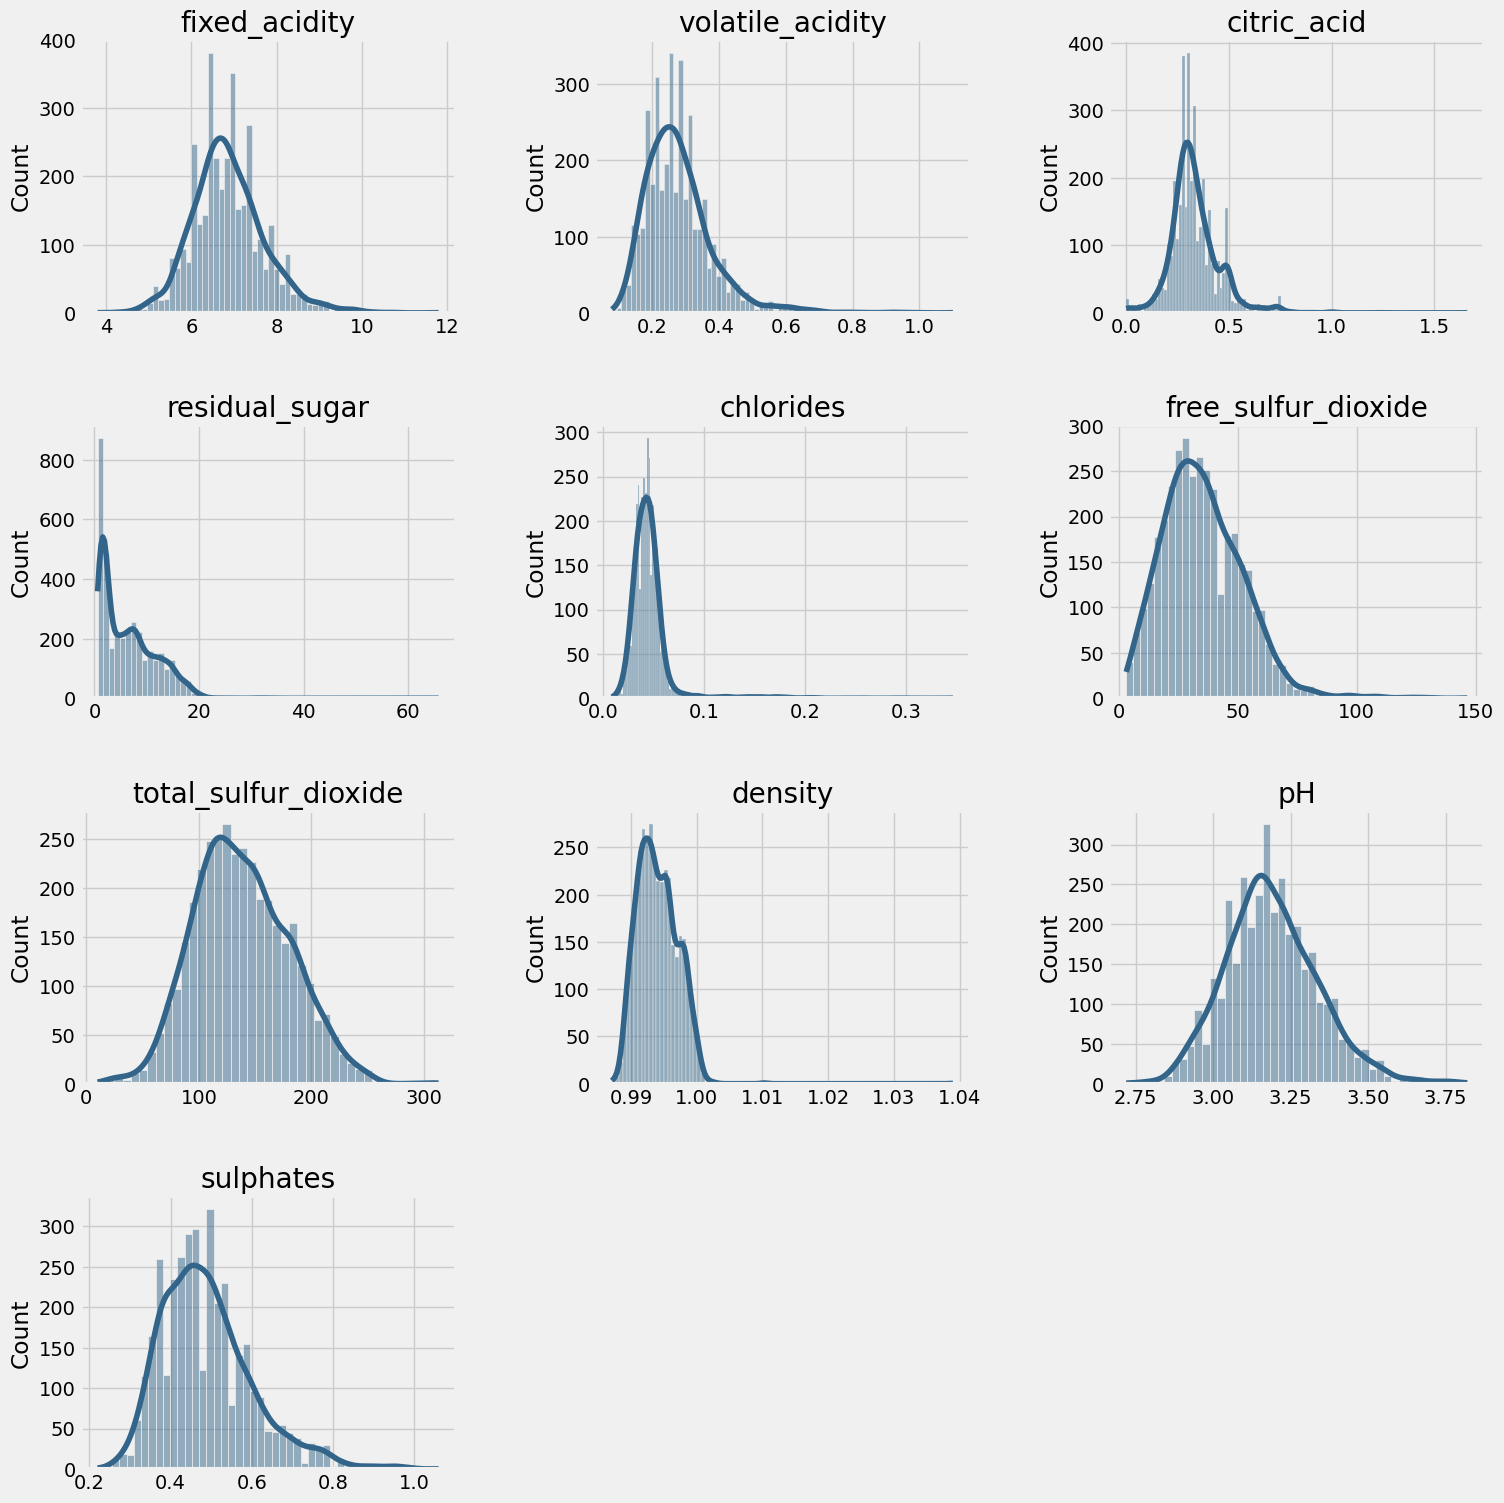

In [6]:
# Plot histograms for train data
fig,ax = plt.subplots(4,3,figsize=(16,16))
count = 0
for item in X_train.columns.tolist():
    sns.histplot(X_train[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-2].set_visible(False)
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

In [7]:
# Plot the training data in box plots

And let us look at the correlation between the features.

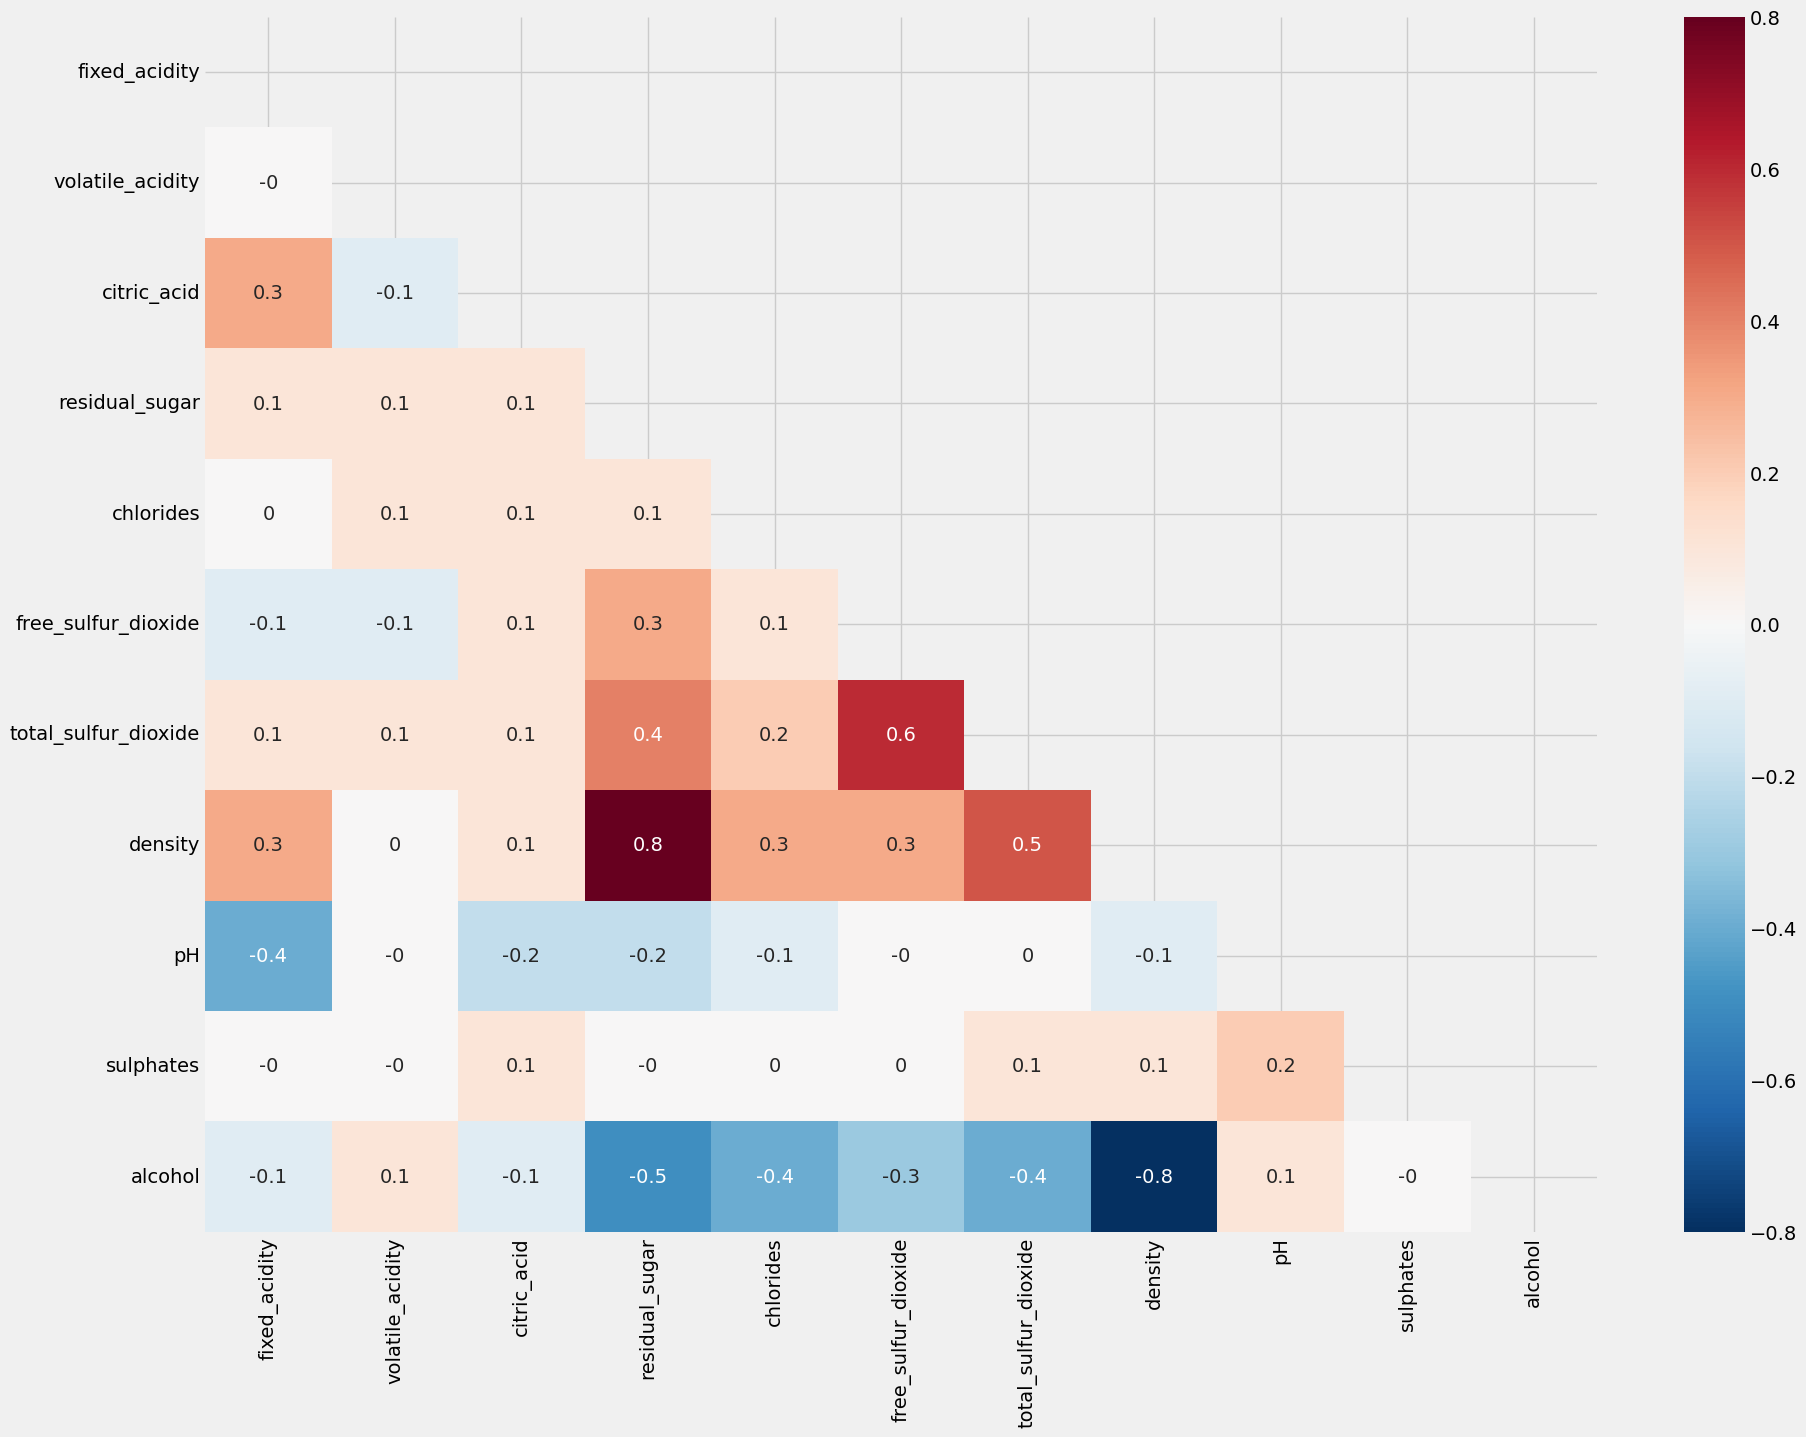

In [8]:
# Plot correlation matrix 
mask = np.triu(df_train.corr())
plt.figure(figsize = (20,15))
ax = sns.heatmap(round(df_train.corr(), 1)
                 ,annot=True
                 ,mask=mask
                 ,cmap='RdBu_r')

Let's have a closer look at individual features starting with Chlorides. If you want to see more features you can of course add cells and apply the code for those you want to have a closer look at!

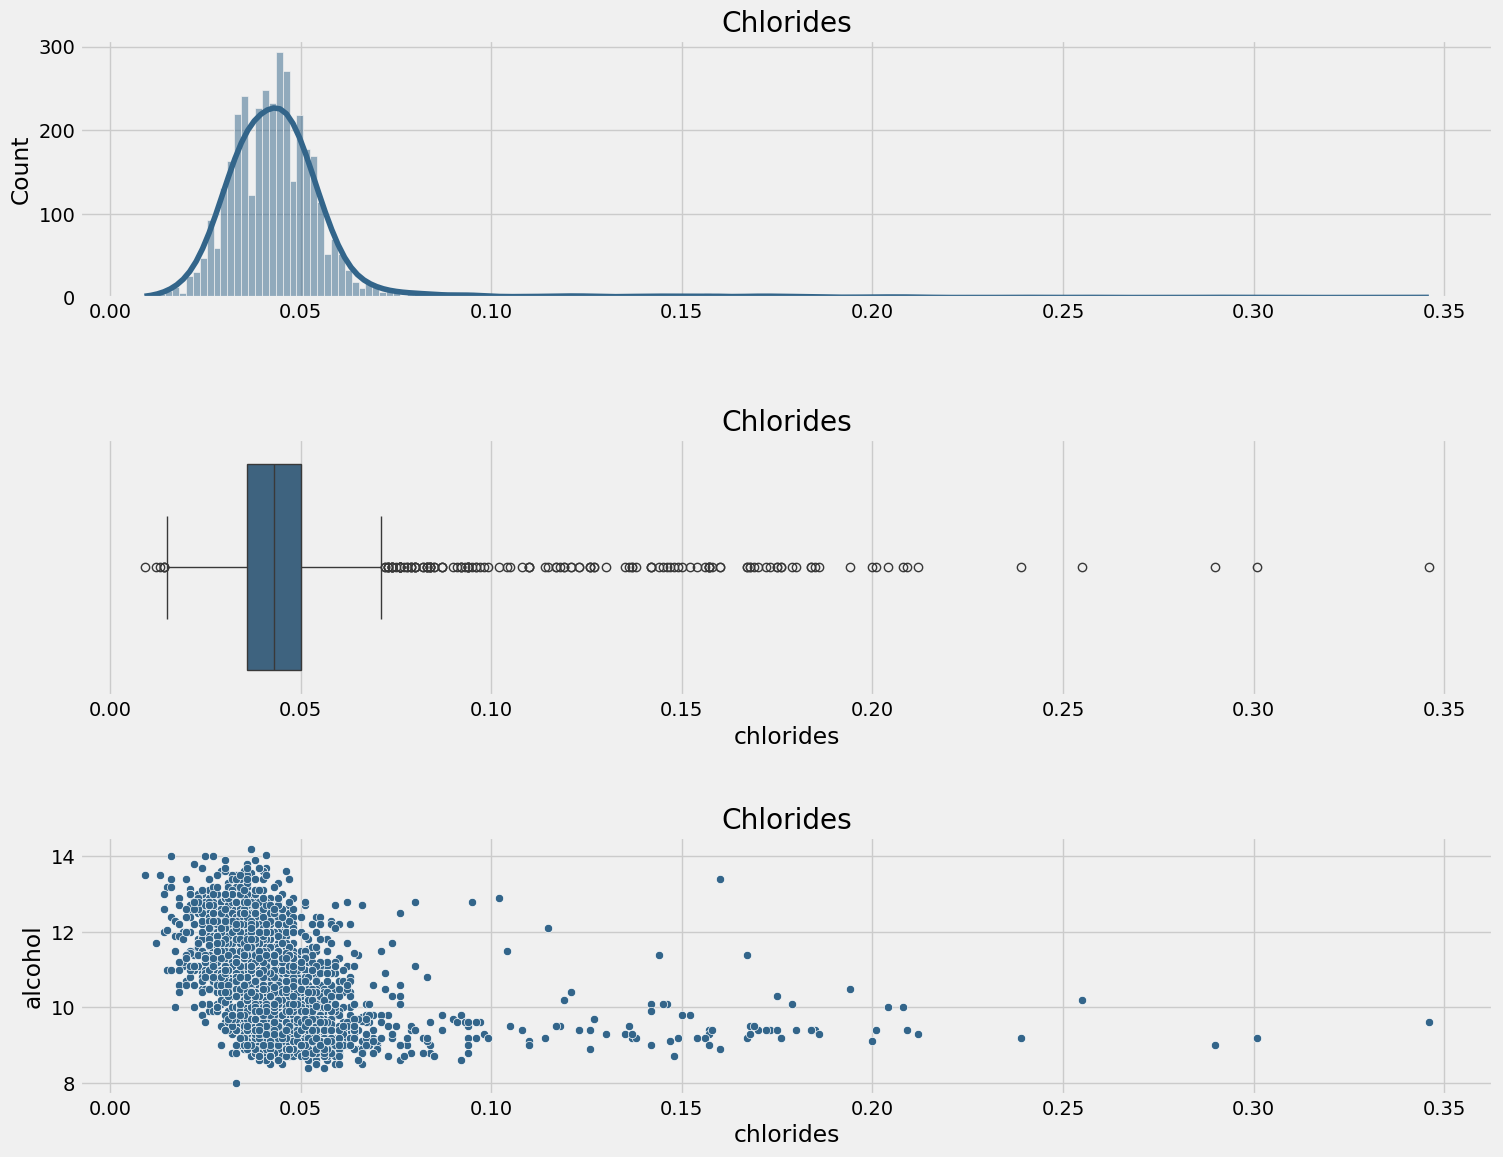

In [9]:
# Plotting one feature with histogram, box plot and scatter plot
fig,ax = plt.subplots(nrows=4,figsize=(16,16))
count = 0
# Histogram
sns.histplot(X_train['chlorides'], kde=True, ax=ax[0], color='#33658A').set(title='Chlorides', xlabel='')
# Box plot
sns.boxplot(x= X_train['chlorides'],ax=ax[1], color='#33658A').set(title='Chlorides')
# Scatter plot
sns.scatterplot(x=X_train.chlorides, y=df_train.alcohol,ax=ax[2], color='#33658A').set(title='Chlorides')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

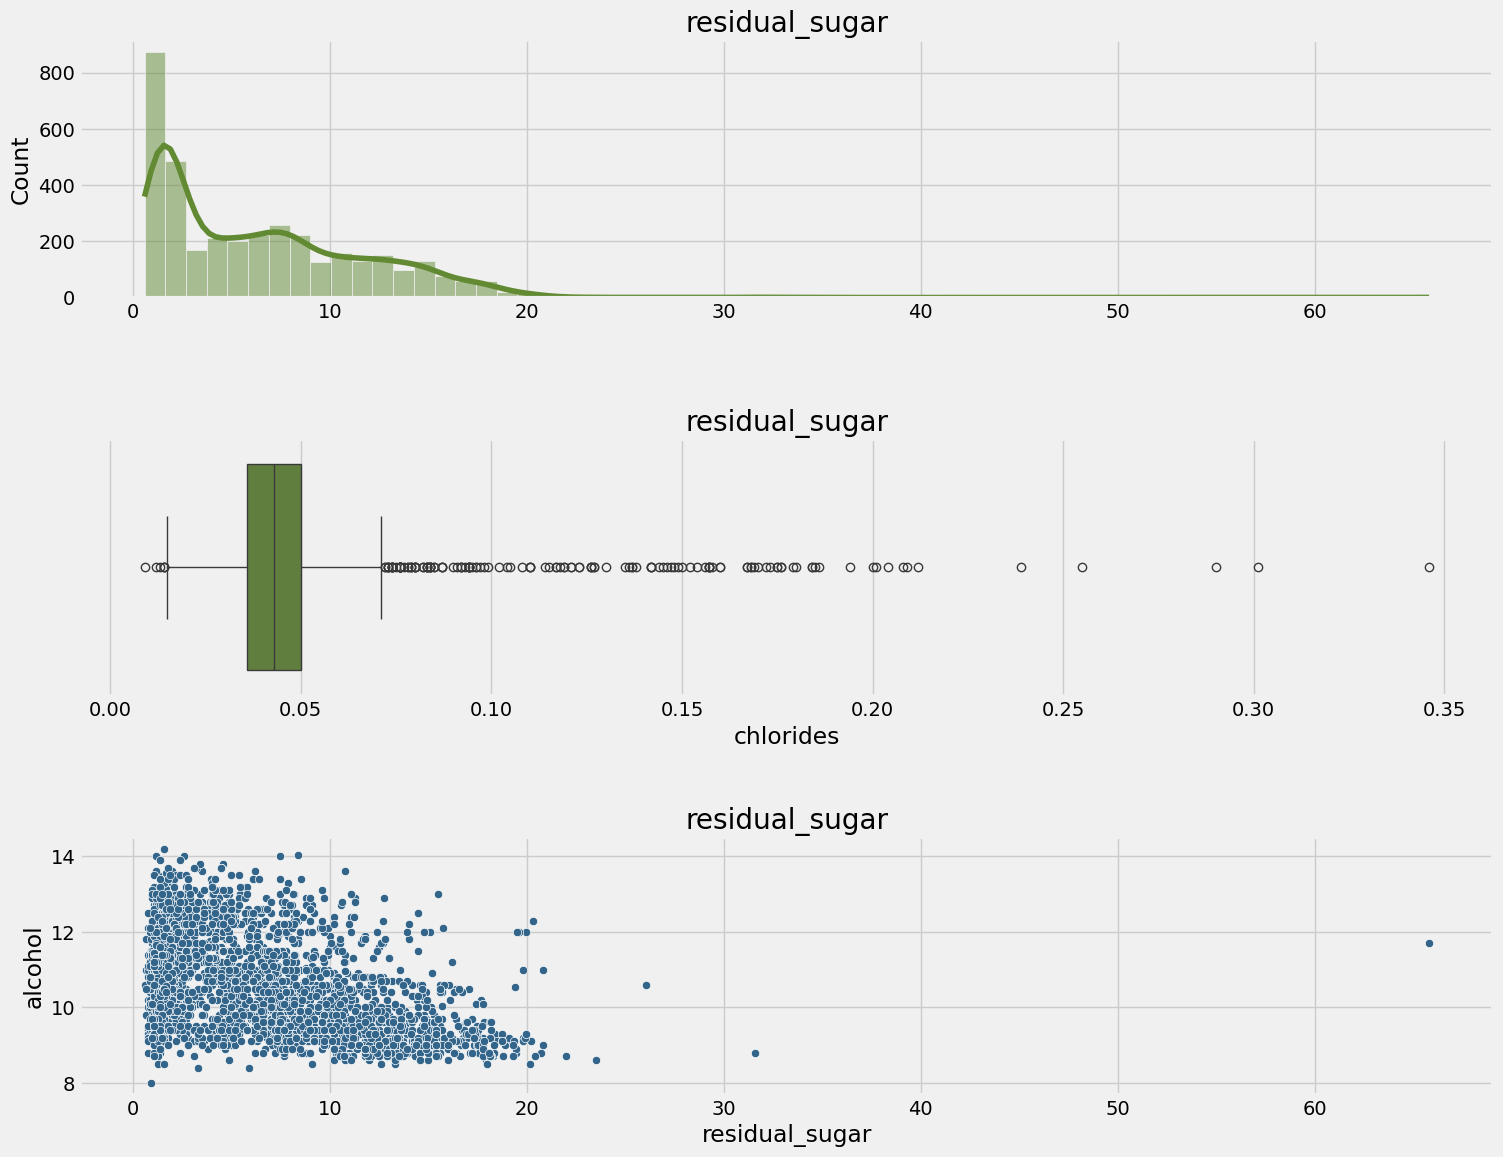

In [10]:
# Plotting one feature with histogram, box plot and scatter plot
fig,ax = plt.subplots(nrows=4,figsize=(16,16))
count = 0
# Histogram
sns.histplot(X_train['residual_sugar'], kde=True, ax=ax[0], color="#618A33").set(title='residual_sugar', xlabel='')
# Box plot
sns.boxplot(x= X_train['chlorides'],ax=ax[1], color="#618A33").set(title='residual_sugar')
# Scatter plot
sns.scatterplot(x=X_train.residual_sugar, y=df_train.alcohol,ax=ax[2], color='#33658A').set(title='residual_sugar')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

You can see that there seem to be outliers at both ends of the distribution. But since the distribution is clearly right skewed, there are more outliers to the right.
A first step if you encounter outliers is to transform the data. Sometimes transforming the data already helps to get rid of them. There are several ways to transform the data, here are some examples:
- Log transformation
- Square root transformation
- Power transformation
- Box-Cox transformation

Let's try the log transformation for our data. As you can see on the histograms above we have several features with skewed data. We will use the transformation on all of them.

In [11]:
# Log-transform skewed features using np.log()
X_train.volatile_acidity = X_train.volatile_acidity.apply(lambda x: np.log(x))
X_train.chlorides = X_train.chlorides.apply(lambda x: np.log(x))
X_train.density = X_train.density.apply(lambda x: np.log(x))
X_train.pH = X_train.pH.apply(lambda x: np.log(x))

Now we can check if the transformation helped us to get rid of the outliers. Let's plot the chlorides column again.

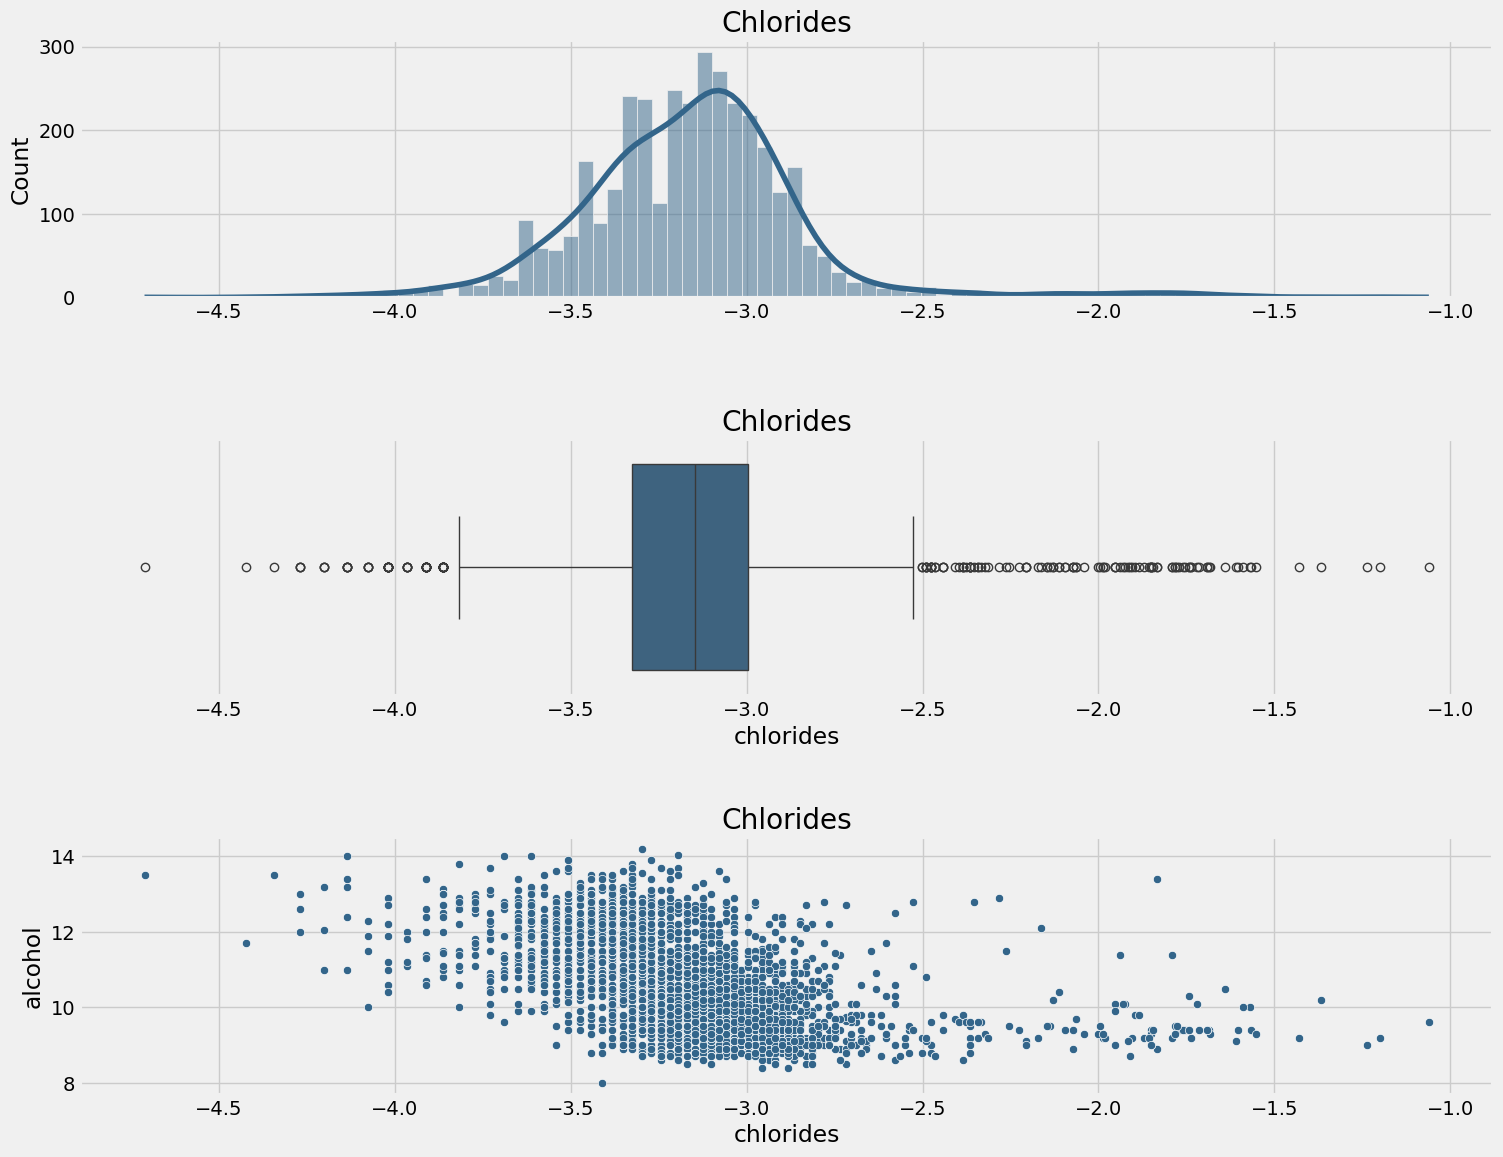

In [13]:
# Plotting one feature with histogram, box plot and scatter plot
fig,ax = plt.subplots(nrows=4,figsize=(16,16))
count = 0
# Histogram
sns.histplot(X_train['chlorides'], kde=True,ax=ax[0], color='#33658A').set(title='Chlorides', xlabel='')
# Box plot
sns.boxplot(x=X_train['chlorides'],ax=ax[1], color='#33658A').set(title='Chlorides')
# Scatter plot
sns.scatterplot(x=X_train.chlorides, y=df_train.alcohol,ax=ax[2], color='#33658A').set(title='Chlorides')
   
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

We got rid of the skewness but there are still outliers. So let's calculate the z-score for the features after the transformation. `Scipy` provides us with an easy way to calculate the z-score for our whole dataset:

In [14]:
# Calculate z-score for whole dataset
df_zscore  = zscore(X_train)

When we are considering to remove outliers based on the z-score or any other threshold, we have to calculate what percentage of the data we would loose. If the proportion we were to remove is too large, we need to reconsider our approach. 

So let's calculate how much rows we would delete if we would remove the outliers with a threshold of 3 standard deviations.

In [15]:
# Calculate data loss based on 3 standard deviations
num_outlier = len(df_train[(np.abs(zscore(df_train)) > 3).any(axis=1)]) / len(df_train) * 100
print(f'{len(df_train[(np.abs(zscore(df_train)) > 3).any(axis=1)])} rows of {len(df_train)} total rows contain outliers.')
print(f'Percentage of data loss: {num_outlier:.2f}%')

289 rows of 3673 total rows contain outliers.
Percentage of data loss: 7.87%


Roughly 8% of the observations in our dataframe contain one or more outliers. 8% is quite a lot, especially when you have a small dataset. Nevertheless, we will continue to create a dataframe without those observations. Therefore, we can calculate the z-score for each column and take the absolute value to query our dataframe and only keep those rows with z-scores lower than 3.

In [16]:
# Calculate z-score and query dataframe to remove rows with z-scores > 3
df_train_wo_outlier = X_train[(np.abs(zscore(df_train.select_dtypes(exclude='object'))) < 3).all(axis=1)]

This way we got rid of the rows in our feature dataframe. But now we have to make sure to drop the corresponding entries in our target variable as well.
To drop the same rows in y_train we have to merge df_train_wo_outlier and y_train and afterwards split them again.

In [17]:
# Remove outliers in target variable 
df_train_wo_outlier = pd.merge(df_train_wo_outlier, y_train, left_index=True, right_index=True)
y_train_wo_outlier = df_train_wo_outlier['alcohol']
X_train_wo_outlier = df_train_wo_outlier.drop('alcohol', axis=1)

That worked! We have removed the outliers from our dataframe. Now let's see how the distribution looks like.

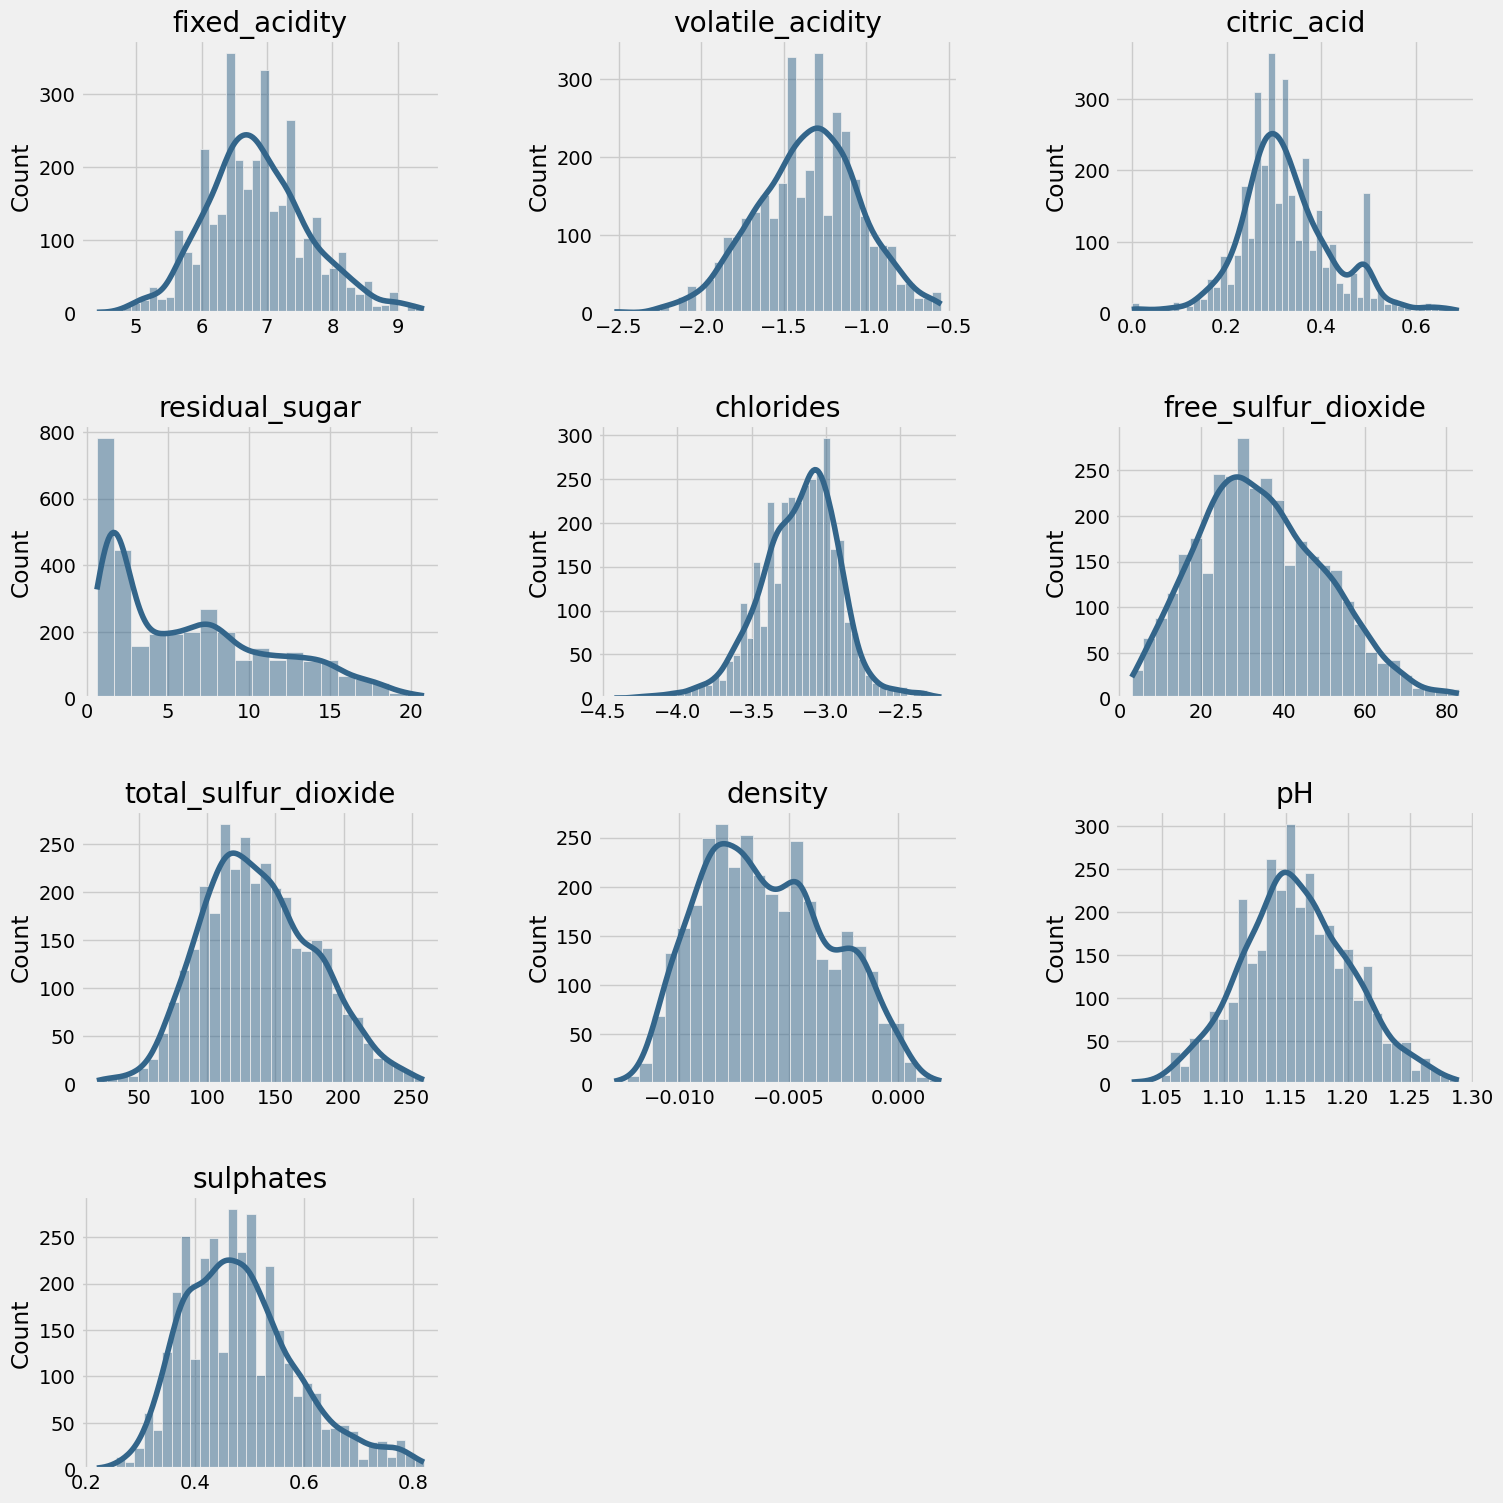

In [18]:
# Plot histograms for cleaned features
fig,ax = plt.subplots(4,3,figsize=(16,16))
count = 0
for item in X_train_wo_outlier.columns.tolist():
    sns.histplot(X_train_wo_outlier[item], kde=True,ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
ax.flat[-2].set_visible(False)
fig.tight_layout(pad=3)

In [ ]:
# And again you can plot the box plots using the code from above

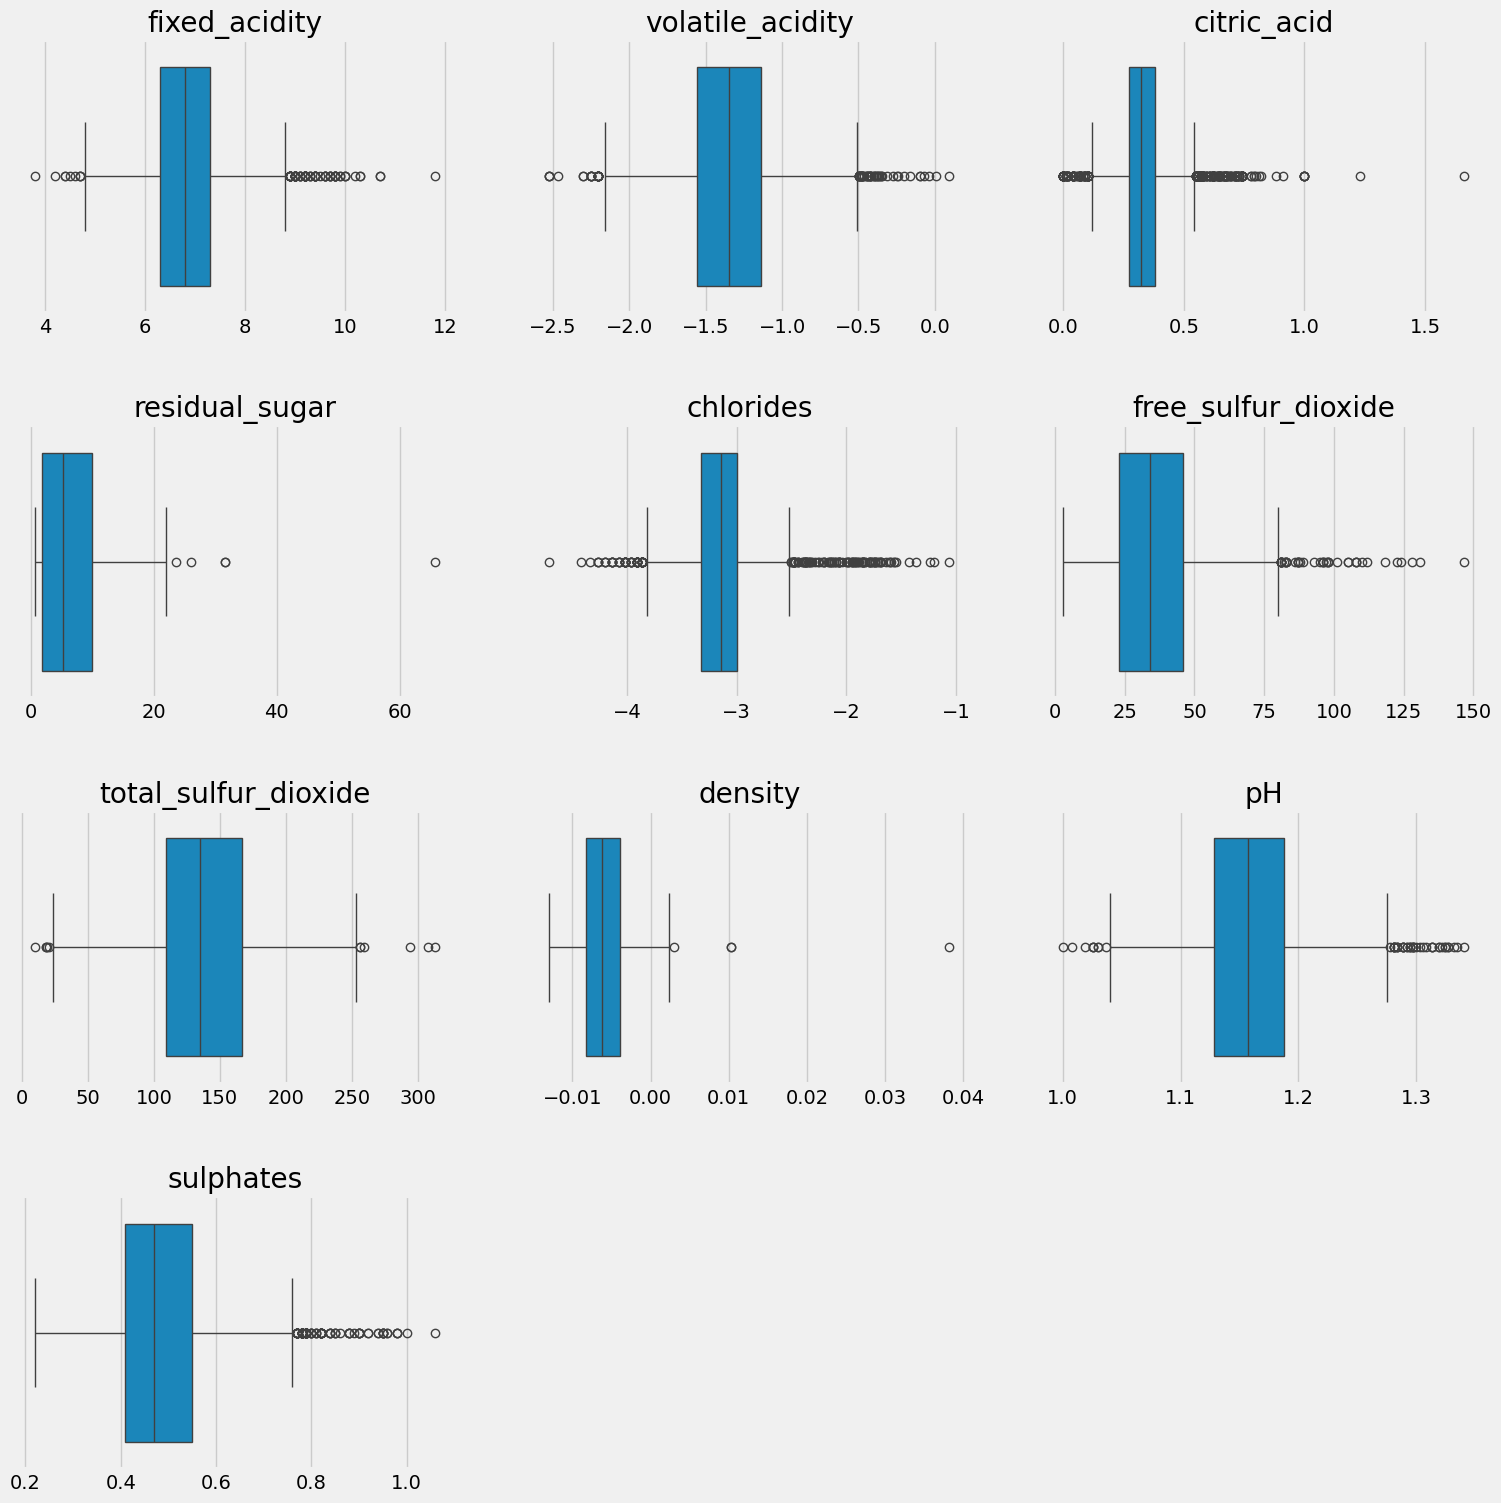

In [20]:
# Plot the training data in box plots (same layout idea as the histograms)

fig, ax = plt.subplots(4, 3, figsize=(16, 16))
count = 0

for col in X_train.columns:
    sns.boxplot(
        x=X_train[col],
        ax=ax[int(count/3)][count % 3]
    ).set(title=col, xlabel="")
    count += 1

# Hide the last two empty axes (because 11 features, 12 slots)
ax.flat[-2].set_visible(False)
ax.flat[-1].set_visible(False)

fig.tight_layout(pad=3)
plt.show()

Did the correlation matrix also change? Let's have a look at the correlation matrix.

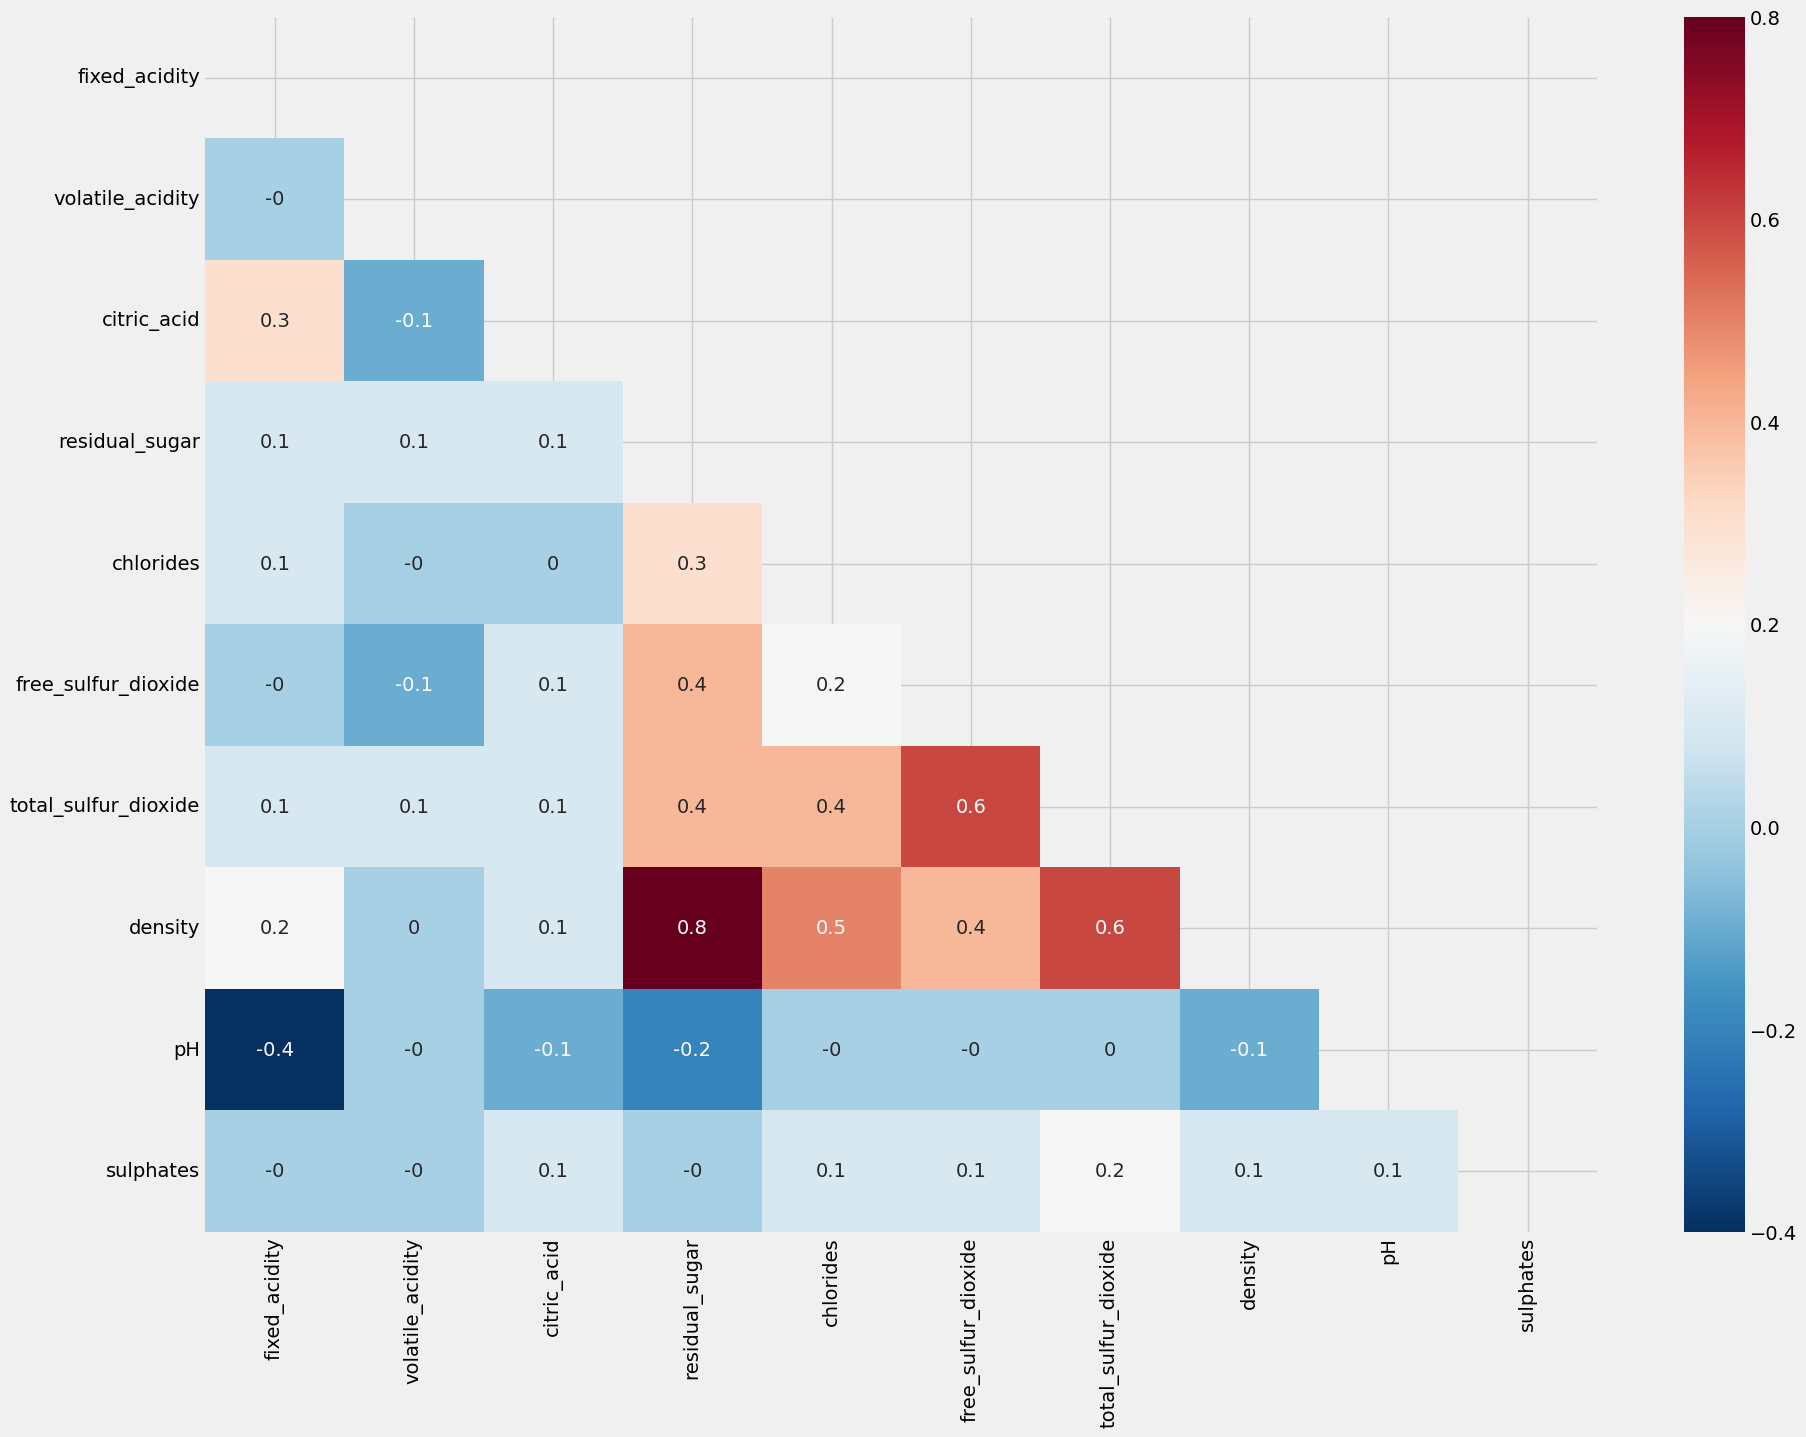

In [19]:
# Plot correlation matrix for cleaned data
mask = np.triu(X_train_wo_outlier.corr())
plt.figure(figsize = (20,15))
ax = sns.heatmap(round(X_train_wo_outlier.corr(),1)
                 ,annot=True
                 ,mask=mask
                 ,cmap='RdBu_r')

## Influence of Outlier Removal on Model Performance



Now let's compare two models. The first one is a simple linear regression model trained on the data without the removal of outliers. The second one is a linear regression model trained on the data with the removal of outliers. Before we can use the test set for evaluating our models we need to transform it the same way the training set was transformed.

In [ ]:
# To-Do: Apply log transformation from train set to test set as well

# Your Code!

In [21]:
# Apply the same log transformations from train set to test set

X_test = X_test.copy()

X_test['volatile_acidity'] = X_test['volatile_acidity'].apply(lambda x: np.log(x))
X_test['chlorides'] = X_test['chlorides'].apply(lambda x: np.log(x))
X_test['density'] = X_test['density'].apply(lambda x: np.log(x))
X_test['pH'] = X_test['pH'].apply(lambda x: np.log(x))

### Model with Outliers

For the model which is trained on the data with outliers we will use `X_train` and `y_train`.

In [23]:
# Instantiate our model 
lin_reg = LinearRegression()

# Fit the model using our train data 
lin_reg.fit(X_train, y_train)

# Make predictions on the train data for r2 and on the test data for the RMSE
y_pred_train  = lin_reg.predict(X_train)
y_pred = lin_reg.predict(X_test)

### Model without Outliers

This model will be trained on our clean data `X_train_wo_outlier` and `y_train_wo_outlier`.

In [ ]:
# To-Do:
# Instantiate the model 


# Fit the model using our train data  with outlier removed and your target variable

# Fit the model using our train data 


#y_pred_test = lin_reg.predict(X_test)
#y_pred_train = lin_reg.predict(X_train)

# Make predictions on the train data for r2 and on the test data for the rsme
y_pred_train_wo_outlier = 
y_pred_wo_outlier = 

In [25]:
# Instantiate the model
lin_reg_wo_outlier = LinearRegression()

# Fit the model using the cleaned training data
lin_reg_wo_outlier.fit(X_train_wo_outlier, y_train_wo_outlier)

# Predictions: train (for R²) and test (for RMSE)
y_pred_train_wo_outlier = lin_reg_wo_outlier.predict(X_train_wo_outlier)
y_pred_wo_outlier = lin_reg_wo_outlier.predict(X_test)

Model without outliers — what’s going on
	•	We train a second Linear Regression model after removing outliers from the training data.
	•	This lets us compare:
	•	a model trained with outliers
	•	vs a model trained on cleaner data

What we do
	1.	Fit a new LinearRegression on the cleaned training set.
	2.	Evaluate:
	•	R² on the cleaned training data (fit quality)
	•	RMSE on the unchanged test set (generalisation)

Why the test set stays the same
	•	The test set represents future, unseen data.
	•	Removing test outliers would leak information and inflate performance.
	•	We only apply the same transformations (e.g. log) so scales match.

What improvement looks like
	•	Smaller gap between train and test performance
	•	Lower test RMSE than the model trained with outliers

In [27]:
from sklearn.metrics import r2_score, root_mean_squared_error

print("MODEL COMPARISON")
print("=" * 40)

print("\nWith outliers:")
print(f"Train R² : {r2_score(y_train, y_pred_train):.3f}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")

print("\nWithout outliers:")
print(f"Train R² : {r2_score(y_train_wo_outlier, y_pred_train_wo_outlier):.3f}")
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_wo_outlier):.3f}")

MODEL COMPARISON

With outliers:
Train R² : 0.860
Test RMSE: 0.377

Without outliers:
Train R² : 0.919
Test RMSE: 0.366


	•	Train R²: how well the model fits the data it was trained on.
	•	Test RMSE: what actually matters — how well it works on new data.
	•	Lower test RMSE after cleaning: outlier removal helped generalization.
	•	Little or no RMSE change: removing outliers probably wasn’t worth losing data.

### Model Comparison

Let's see if our efforts have paid off:

In [26]:
from sklearn.metrics import root_mean_squared_error

print('With outliers:')
print("R-squared: ", round(r2_score(y_train, y_pred_train), 3))
print("RMSE: ", round(root_mean_squared_error(y_test, y_pred), 3))
print('-----------------------------------')
print('Without outliers:')
print("R-squared: ", round(r2_score(y_train_wo_outlier, y_pred_train_wo_outlier), 3))
print("RMSE: ", round(root_mean_squared_error(y_test, y_pred_wo_outlier), 3))


With outliers:
R-squared:  0.86
RMSE:  0.377
-----------------------------------
Without outliers:
R-squared:  0.919
RMSE:  0.366


Apparently, we did a good job! The model trained with the clean data outperforms the other model in both metrics.

## Final Remark



Handle this notebook with care! We showed you how you can remove outliers using the z-score method. But we didn't dive into the business question if it makes sense to remove all the outliers from the dataset or if they are legitimate special cases of the feature. You want to loose as little data as possible. Because of course if you remove data from the dataset the model will also not be able to learn something about those cases. So, you should be careful and remove them only if it makes sense both from a mathematical/statistical and a business point of view.

In some cases you can also remove outlier from your target variable, but you have to be sure that it makes sense in business perspective and you have to track the variable in production to be sure that the outlier will not appear often or if the distribution of the data changes. Because if you model doesn't work for all customers you may loose them.

Here is also a good article on when [To Drop or Not to Drop](https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/)!